# Evaluate Ensemble

This notebook combines the classification results of some models via logit-ensembling way.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import os
import sys
import pickle
from copy import deepcopy
import hydra
from omegaconf import OmegaConf
from collections import OrderedDict
import json

import numpy as np
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import pprint
import wandb
import matplotlib
import matplotlib.pyplot as plt

# custom package
from datasets.caueeg_script import build_dataset_for_train
from datasets.pipeline import EegAgeBias
import models
from train.evaluate import check_accuracy
from train.evaluate import check_accuracy_extended
from train.evaluate import check_accuracy_extended_debug
from train.evaluate import check_accuracy_multicrop
from train.evaluate import check_accuracy_multicrop_extended
from train.evaluate import calculate_confusion_matrix
from train.evaluate import calculate_confusion_matrix2
from train.evaluate import calculate_class_wise_metrics
from train.visualize import draw_roc_curve
from train.visualize import draw_confusion, draw_confusion2
from train.visualize import draw_class_wise_metrics
from train.visualize import draw_error_table
from train.visualize import annotate_heatmap

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 2.0.0+cu117
cuda is available.


-----

## List up the models to check accuracy

In [4]:
model_names = [
    'lo88puq7',  # 2D-VGG-19
    'l8524nml',  # 1D-ResNet-18   // 2s1700lg, l8524nml
    'v301o425',  # 1D-ResNeXt-50 
    '1sl7ipca',  # 2D-ResNeXt-50 
    'gvqyvmrj',  # 1D-ResNet-50 
    'gjkysllw',  # 2D-ViT-B-16 
    'xci5svkl',  # 2D-ResNet-18 
    '1vc80n1f',  # 1D-VGG-19 
    'syrx7bmk',  # 2D-ResNet-50 
]

# model_names = [
#     'tp7qn5hd',  # 1D-ResNeXt-50 
#     'q1hhkmik',  # 1D-ResNet-50
#     '0svudowu',  # 2D-ResNeXt-50
#     'ruqd8r7g',  # 2D-VGG-19
#     'dn10a6bv',  # 2D-ResNet-18
#     'atbhqdgg',  # 2D-ResNet-50
#     '4439k9pg',  # 1D-ResNet-18
#     'nemy8ikm',  # 1D-VGG-19
#     '1cdws3t5',  # 2D-ViT-B-16
# ]

model_pool = []

for model_name in model_names:
    path = os.path.join(r'./local/checkpoint', model_name, 'checkpoint.pt')
    try:
        ckpt = torch.load(path, map_location=device)
        print(ckpt['config']['model'])
        model_pool.append({'name': model_name, 'path': path, 'model': ckpt['config']['model']})
    except Exception as e:
        print(e)
        print(f'- checkpoint cannot be opened: {path}')
        
pprint.pprint([model_dict['name'] for model_dict in model_pool])

2D-VGG-19
1D-ResNet-18
1D-ResNeXt-50
2D-ResNeXt-50
1D-ResNet-50
2D-ViT-B-16
2D-ResNet-18
1D-VGG-19
2D-ResNet-50
['lo88puq7',
 'l8524nml',
 'v301o425',
 '1sl7ipca',
 'gvqyvmrj',
 'gjkysllw',
 'xci5svkl',
 '1vc80n1f',
 'syrx7bmk']


---

## Configurations

In [5]:
# age_changes = np.concatenate((np.arange(-10, 0, 2), np.arange(2, 11, 2)))
age_changes = np.arange(-16, -10, 2)

task = 'exp-dementia-age-change'
no_patient_overlap = False
eval_ensemble = True

base_repeat = 800 # 800
crop_multiple = 8
test_crop_multiple = 8

verbose = False
save_fig = True

eval_train = False
eval_val = False
eval_test = True
eval_test_multi = True

-----

## Evaluate each model and accumulate the logits

In [ ]:
summary = {
    model_dict['model']: {
        'Test': [],
        'TTA': []
    } for model_dict in model_pool
}
summary['range'] = [int(age_bias) for age_bias in age_changes]
summary['ensemble'] = {
    'Test': [],
    'TTA': []
}

os.makedirs(os.path.join("local/output", task), exist_ok=True)

for age_bias in age_changes:
    print('-' * 50, f'age_bias: {age_bias:+03}', '-' * 50)
    folderbase = os.path.join("local/output", task, f"{age_bias:+03}")
    os.makedirs(folderbase, exist_ok=True)

    for model_dict in model_pool:
        if model_dict['name'] == 'Ensemble':
            continue
        
        # load and parse the checkpoint
        ckpt = torch.load(model_dict['path'], map_location=device)
        model_state = ckpt['model_state']
        config = ckpt['config']
        
        model_dict['model'] = config['model']
        model_dict['num_params'] = config.get('num_params', '???')
        model_dict['model size (MiB)'] = sys.getsizeof(pickle.dumps(model_state)) / (1024 * 1024)
    
        if no_patient_overlap:
            config['task'] += '-no-overlap' 
    
        
        if '220419' in config['dataset_path']:
            config['dataset_path'] = './local/dataset/caueeg-dataset/'
        config['run_mode'] = 'eval'
        
        model_dict['seq_length'] = config['seq_length']
        model_dict['use_age'] = config['use_age']
        model_dict['photic'] = config['photic']
        model_dict['EKG'] = config['EKG']
    
        model_dict['awgn'] = config.get('awgn', 0)
        model_dict['awgn_age'] = config.get('awgn_age', 0)
        model_dict['mgn'] = config.get('mgn', 0)
        model_dict['mixup'] = config.get('mixup', 0)
        model_dict['dropout'] = config.get('dropout', 0)
        model_dict['weight_decay'] = config.get('weight_decay', '???')
        model_dict['fc_stages'] = config.get('fc_stages', 1)
        model_dict['activation'] = config.get('activation', 0)
    
        model_dict['minibatch'] = round(config['minibatch'])
        model_dict['total_samples'] = round(config.get('total_samples', config['iterations'] * config['minibatch']))
        model_dict['base_lr'] = config.get('base_lr', config.get('LR', '???'))
        model_dict['lr_scheduler_type'] = config.get('lr_scheduler_type', 'constant_with_decay')
        model_dict['warmup_steps'] = config.get('warmup_steps', '???')
        model_dict['seed'] = config.get('seed', '???')
        
        print('- checking for', model_dict['name'], config['model'], '...')
        
        # initiate the model
        if '_target_' in config:
            model = hydra.utils.instantiate(config).to(device)
        elif type(config['generator']) is str:
            config['generator'] = getattr(models, config['generator'].split('.')[-1])
            if 'block' in config:
                config['block'] = getattr(models, config['block'].split('.')[-1])
            model = config['generator'](**config).to(device)
        else:
            if 'block' in config:
                if config['block'] == models.resnet_1d.BottleneckBlock1D:
                    config['block'] = 'bottleneck'
                elif config['block'] == models.resnet_2d.Bottleneck2D:
                    config['block'] = 'bottleneck'
                elif config['block'] == models.resnet_1d.BasicBlock1D:
                    config['block'] = 'basic'
                elif config['block'] == models.resnet_2d.BasicBlock2D:
                    config['block'] = 'basic'
                    
            model = config['generator'](**config).to(device)
        
        if config.get('ddp', False):
            model_state_ddp = deepcopy(model_state)
            model_state = OrderedDict()
            for k, v in model_state_ddp.items():
                name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
                model_state[name] = v
        
        model.load_state_dict(model_state)
        
        # reconfigure and update
        config.pop('cwd', 0)
        config['ddp'] = False
        config['crop_multiple'] = crop_multiple
        config['test_crop_multiple'] = test_crop_multiple
        config['crop_timing_analysis'] = False
        config['eval'] = True
        config['device'] = device
        
        repeat = round(base_repeat / crop_multiple)
        model_dict['repeat'] = repeat
        model_dict['crop_multiple'] = crop_multiple
        model_dict['test_crop_multiple'] = test_crop_multiple
        
        # build dataset
        _ = build_dataset_for_train(config, verbose=verbose)
        train_loader = _[0]
        val_loader = _[1]
        test_loader = _[2]
        multicrop_test_loader = _[3]

        preprocess_test_age_bias = torch.nn.Sequential(*[EegAgeBias(age_bias), *config['preprocess_test']])

        
        # warm-up stage
        _ = check_accuracy_extended(model, test_loader, 
                                    preprocess_test_age_bias, config, repeat=1)
        
        # train accuracy
        if eval_train:
            train_acc = check_accuracy(model, train_loader, 
                                       preprocess_test_age_bias, config, repeat=repeat)
            model_dict['Train Accuracy'] = train_acc
        
        # val accuracy
        if eval_val:
            val_acc = check_accuracy(model, val_loader, 
                                     preprocess_test_age_bias, config, repeat=repeat)
            model_dict['Validation Accuracy'] = val_acc
        
        # Test accuracy
        if eval_test:
            _ = check_accuracy_extended(model, test_loader, 
                                        preprocess_test_age_bias, config, repeat=repeat)
            model_dict['Test Throughput'] = _[4]
            model_dict['Test Accuracy'] = _[0]
            model_dict['Test Score'] = _[1]
            model_dict['Test Target'] = _[2]
            summary[model_dict['model']]['Test'].append(model_dict['Test Accuracy'])
            
            pred =  model_dict['Test Score'].argmax(axis=-1)
            target = model_dict['Test Target']
            test_confusion = calculate_confusion_matrix2(pred, target, model_dict['Test Score'].shape[-1], 
                                                         len(test_loader.dataset)) 
            test_class_wise_metrics = calculate_class_wise_metrics(test_confusion.sum(axis=0))
    
            for k, v in test_class_wise_metrics.items():
                for c in range(config['out_dims']):
                    c_name = config['class_label_to_name'][c]
                    model_dict[f'{k} ({c_name})'] = test_class_wise_metrics[k][c]
                
            if save_fig:
                draw_roc_curve(model_dict['Test Score'], 
                               model_dict['Test Target'], 
                               config['class_label_to_name'], 
                               use_wandb=False, 
                               save_path=f'{folderbase}/{model_dict["name"]}-ROC.pdf')
    
                draw_confusion(test_confusion.sum(axis=0), 
                               config['class_label_to_name'], 
                               use_wandb=False, 
                               save_path=f'{folderbase}/{model_dict["name"]}-confusion.pdf')
    
                draw_confusion2(test_confusion.mean(axis=0), 
                                test_confusion.std(axis=0), 
                                config['class_label_to_name'], 
                                use_wandb=False, 
                                save_path=f'{folderbase}/{model_dict["name"]}-confusion2.pdf')
    
                draw_class_wise_metrics(test_confusion.sum(axis=0), 
                                        config['class_label_to_name'], 
                                        use_wandb=False, 
                                        save_path=f'{folderbase}/{model_dict["name"]}-class-wise.pdf')
        # Multi-crop test accuracy
        if eval_test_multi:
            _ = check_accuracy_multicrop_extended(model, multicrop_test_loader, 
                                                  preprocess_test_age_bias, config, repeat=repeat)
            model_dict['Multi-Crop Test Throughput'] = _[4]
            model_dict['Multi-Crop Test Accuracy'] = _[0]
            model_dict['Multi-Crop Test Score'] = _[1]
            model_dict['Multi-Crop Test Target'] = _[2]
            summary[model_dict['model']]['TTA'].append(model_dict['Multi-Crop Test Accuracy'])
            
            pred =  model_dict['Multi-Crop Test Score'].argmax(axis=-1)
            target = model_dict['Multi-Crop Test Target']
            multi_test_confusion = calculate_confusion_matrix2(pred, target, model_dict['Test Score'].shape[-1], 
                                                               len(test_loader.dataset)) 
            multi_test_class_wise_metrics = calculate_class_wise_metrics(multi_test_confusion.sum(axis=0))
    
            for k, v in multi_test_class_wise_metrics.items():
                for c in range(config['out_dims']):
                    c_name = config['class_label_to_name'][c]
                    model_dict[f'Multi-Crop {k} ({c_name})'] = multi_test_class_wise_metrics[k][c]
    
            if save_fig:
                draw_roc_curve(model_dict['Multi-Crop Test Score'], 
                               model_dict['Multi-Crop Test Target'], 
                               config['class_label_to_name'], 
                               use_wandb=False, 
                               save_path=f'{folderbase}/{model_dict["name"]}-roc-tta.pdf')
    
                draw_confusion(multi_test_confusion.sum(axis=0), 
                               config['class_label_to_name'], 
                               use_wandb=False, 
                               save_path=f'{folderbase}/{model_dict["name"]}-confusion-tta.pdf')
                
                draw_confusion2(multi_test_confusion.mean(axis=0), 
                                multi_test_confusion.std(axis=0), 
                                config['class_label_to_name'], 
                                use_wandb=False, 
                                save_path=f'{folderbase}/{model_dict["name"]}-confusion2-tta.pdf')
    
                draw_class_wise_metrics(multi_test_confusion.sum(axis=0), 
                                        config['class_label_to_name'], 
                                        use_wandb=False, 
                                        save_path=f'{folderbase}/{model_dict["name"]}-class-wise-tta.pdf') 
            
    if eval_ensemble:
        if 'Ensemble' == model_pool[-1]['name']:
            model_pool.remove(model_pool[-1])     
    
        # conduct ensembling
        if eval_test:
            ensem_test_score = np.zeros_like(model_pool[0]['Test Score'])
            ensem_test_latency = 0
    
        if eval_test_multi:
            ensem_multi_test_score = np.zeros_like(model_pool[0]['Multi-Crop Test Score'])
            ensem_multi_test_latency = 0
    
        ensem_params = 0
        ensem_model_size = 0
    
        for model_dict in model_pool:        
            ensem_params += model_dict['num_params']
            ensem_model_size += model_dict['model size (MiB)']
    
            if eval_test:
                ensem_test_score += model_dict['Test Score'] / len(model_pool)
                ensem_test_latency += 1 / model_dict['Test Throughput']
    
            if eval_test_multi:
                ensem_multi_test_score += model_dict['Multi-Crop Test Score'] / len(model_pool)
                ensem_multi_test_latency += 1 / model_dict['Multi-Crop Test Throughput']
                
        # test accuracy
        if eval_test:
            # confusion matrix
            pred = ensem_test_score.argmax(axis=-1)
            target = model_pool[0]['Test Target']
            ensem_test_acc = 100.0 * (pred.squeeze() == target).sum() / pred.shape[0]
            summary['ensemble']['Test'].append(ensem_test_acc)
    
            ensem_test_confusion = calculate_confusion_matrix2(pred, target, ensem_test_score.shape[-1], 
                                                               len(test_loader.dataset))
            ensem_test_class_wise_metrics = calculate_class_wise_metrics(ensem_test_confusion.sum(axis=0))
    
            # draw
            save_path = f'{folderbase}/0ensemble-confusion.pdf' if save_fig else None
            draw_confusion(ensem_test_confusion.sum(axis=0), config['class_label_to_name'], 
                           normalize=True, use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-confusion2.pdf' if save_fig else None
            draw_confusion2(ensem_test_confusion.mean(axis=0), ensem_test_confusion.std(axis=0), 
                            config['class_label_to_name'], use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-roc.pdf' if save_fig else None
            draw_roc_curve(ensem_test_score, model_pool[0]['Test Target'], config['class_label_to_name'], 
                           use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-class-wise.pdf' if save_fig else None
            draw_class_wise_metrics(ensem_test_confusion.sum(axis=0), config['class_label_to_name'], 
                                use_wandb=False, save_path=save_path, percent=True)
            
        # multi-crop accuracy
        if eval_test_multi:
            # confusion matrix
            pred = ensem_multi_test_score.argmax(axis=-1)
            target = model_pool[0]['Multi-Crop Test Target']
            ensem_multi_test_acc = 100.0 * (pred.squeeze() == target).sum() / pred.shape[0]
            summary['ensemble']['TTA'].append(ensem_multi_test_acc)
    
            ensem_multi_test_confusion = calculate_confusion_matrix2(pred, target, ensem_multi_test_score.shape[-1], 
                                                                     len(test_loader.dataset))
            ensem_multi_test_class_wise_metrics = calculate_class_wise_metrics(ensem_multi_test_confusion.sum(axis=0))
    
            # draw
            save_path = f'{folderbase}/0ensemble-confusion-tta.pdf' if save_fig else None
            draw_confusion(ensem_multi_test_confusion.sum(axis=0), config['class_label_to_name'], 
                           normalize=True, use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-confusion-tta2.pdf' if save_fig else None
            draw_confusion2(ensem_multi_test_confusion.mean(axis=0), ensem_multi_test_confusion.std(axis=0), 
                            config['class_label_to_name'], use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-roc-tta.pdf' if save_fig else None
            draw_roc_curve(ensem_multi_test_score, model_pool[0]['Multi-Crop Test Target'], config['class_label_to_name'], 
                           use_wandb=False, save_path=save_path)
    
            save_path = f'{folderbase}/0ensemble-class-wise-tta.pdf' if save_fig else None
            draw_class_wise_metrics(ensem_multi_test_confusion.sum(axis=0), config['class_label_to_name'], 
                                    use_wandb=False, save_path=save_path, percent=True)
            
        # summarize the ensemble results
        ensem_dict = {}
    
        ensem_dict['name'] = 'Ensemble'
        ensem_dict['num_params'] = ensem_params
        ensem_dict['model size (MiB)'] = ensem_model_size
    
        if eval_test:
            ensem_dict['Test Throughput'] = 1 / ensem_test_latency
            ensem_dict['Test Accuracy'] = ensem_test_acc
    
            for k, v in ensem_test_class_wise_metrics.items():
                for c in range(config['out_dims']):
                    c_name = config['class_label_to_name'][c]
                    ensem_dict[f'{k} ({c_name})'] = ensem_test_class_wise_metrics[k][c]
    
        if eval_test_multi:
            ensem_dict['Multi-Crop Test Throughput'] = 1 / ensem_multi_test_latency
            ensem_dict['Multi-Crop Test Accuracy'] = ensem_multi_test_acc
    
            for k, v in ensem_multi_test_class_wise_metrics.items():
                for c in range(config['out_dims']):
                    c_name = config['class_label_to_name'][c]
                    ensem_dict[f'Multi-Crop {k} ({c_name})'] = ensem_multi_test_class_wise_metrics[k][c]
    
        model_pool.append(ensem_dict)

        model_pool_frame = deepcopy(model_pool)
        
        for model_dict in model_pool_frame:
            model_dict.pop('Test Score', None)
            model_dict.pop('Test Target', None)
            model_dict.pop('Multi-Crop Test Score', None)
            model_dict.pop('Multi-Crop Test Target', None)
            
        pd.DataFrame(model_pool_frame).to_csv(f'{folderbase}/{task}.csv')
        pd.DataFrame(model_pool_frame)

with open(os.path.join("local/output", task, 'summary0.json'), 'w') as file:
    json.dump(summary, file)

-------------------------------------------------- age_bias: -16 --------------------------------------------------
- checking for lo88puq7 2D-VGG-19 ...
- checking for l8524nml 1D-ResNet-18 ...
- checking for v301o425 1D-ResNeXt-50 ...
- checking for 1sl7ipca 2D-ResNeXt-50 ...
- checking for gvqyvmrj 1D-ResNet-50 ...
- checking for gjkysllw 2D-ViT-B-16 ...
- checking for xci5svkl 2D-ResNet-18 ...
- checking for 1vc80n1f 1D-VGG-19 ...
- checking for syrx7bmk 2D-ResNet-50 ...
-------------------------------------------------- age_bias: -14 --------------------------------------------------
- checking for lo88puq7 2D-VGG-19 ...
- checking for l8524nml 1D-ResNet-18 ...


In [ ]:
pprint.pprint(summary)

## Draw the Results

In [4]:
task = 'exp-dementia-age-change'

with open(f"./local/output/{task}/summary.json") as file:
    summary = json.load(file)
summary['ViT-B-16'] = summary.pop('2D-ViT-B-16')
summary['Ensemble'] = summary.pop('ensemble')

pprint.pprint(summary)

{'1D-ResNeXt-50': {'TTA': [59.19491525423729,
                           61.57627118644068,
                           63.66101694915254,
                           66.46610169491525,
                           69.11016949152543,
                           70.61016949152543,
                           71.56779661016948,
                           70.21186440677965,
                           68.58474576271186,
                           66.77966101694915,
                           63.47457627118644,
                           62.0593220338983,
                           61.22033898305085,
                           59.06779661016949,
                           57.50847457627118,
                           55.1271186440678,
                           51.95762711864407],
                   'Test': [57.96398305084745,
                            60.730932203389834,
                            62.96610169491525,
                            64.7457627118644,
                            66.

In [5]:
# if 'dementia' in task:
#     ref = {
#         '1D-VGG-19':      {'Test': [64.10275424], 'TTA': [66.80508475]},
#         '1D-ResNet-18':   {'Test': [65.52648305], 'TTA': [67.54237288]},
#         '1D-ResNet-50':   {'Test': [61.70868644], 'TTA': [66.8559322]},
#         '1D-ResNeXt-50':  {'Test': [65.53707627], 'TTA': [68.25423729]},
#         '2D-VGG-19':      {'Test': [68.34745763], 'TTA': [70.18644068]},
#         '2D-ResNet-18':   {'Test': [63.53495763], 'TTA': [65.83050847]},
#         '2D-ResNet-50':   {'Test': [65.40042373], 'TTA': [67.27118644]},
#         '2D-ResNeXt-50':  {'Test': [64.61758475], 'TTA': [67.69491525]},
#         'ViT-B-16':       {'Test': [61.3654661], 'TTA': [65.66949153]},
#         'ensemble':       {'Test': [73.63877119], 'TTA': [75.3220339]},
#     }
# elif 'abnormal' in task:
#     ref = {
#         '1D-VGG-19':      {'Test': [72.44852941], 'TTA': [74.27647059]},
#         '1D-ResNet-18':   {'Test': [73.60294118], 'TTA': [74.85294118]},
#         '1D-ResNet-50':   {'Test': [74.11470588], 'TTA': [76.37058824]},
#         '1D-ResNeXt-50':  {'Test': [72.37058824], 'TTA': [77.31764706]},
#         '2D-VGG-19':      {'Test': [72.12941176], 'TTA': [75.39411765]},
#         '2D-ResNet-18':   {'Test': [73.50441176], 'TTA': [75.18823529]},
#         '2D-ResNet-50':   {'Test': [73.06176471], 'TTA': [74.95882353]},
#         '2D-ResNeXt-50':  {'Test': [72.83529412], 'TTA': [75.84705882]},
#         'ViT-B-16':       {'Test': [70.69705882], 'TTA': [72.7]},
#         'ensemble':       {'Test': [78.77665441], 'TTA': [79.16271347]},
#     }

# sorted_indices = np.argsort(np.concatenate((np.array(summary['range']), np.array([0]))))
# summary['range'] = np.concatenate((np.array(summary['range']), np.array([0])))[sorted_indices]

# for model, perf in summary.items():
#     if model in ['range', 'ensemble']:
#         continue
    
#     perf['Test'] = np.concatenate((perf['Test'], ref[model]['Test']))[sorted_indices]
#     perf['TTA'] = np.concatenate((perf['TTA'], ref[model]['TTA']))[sorted_indices]

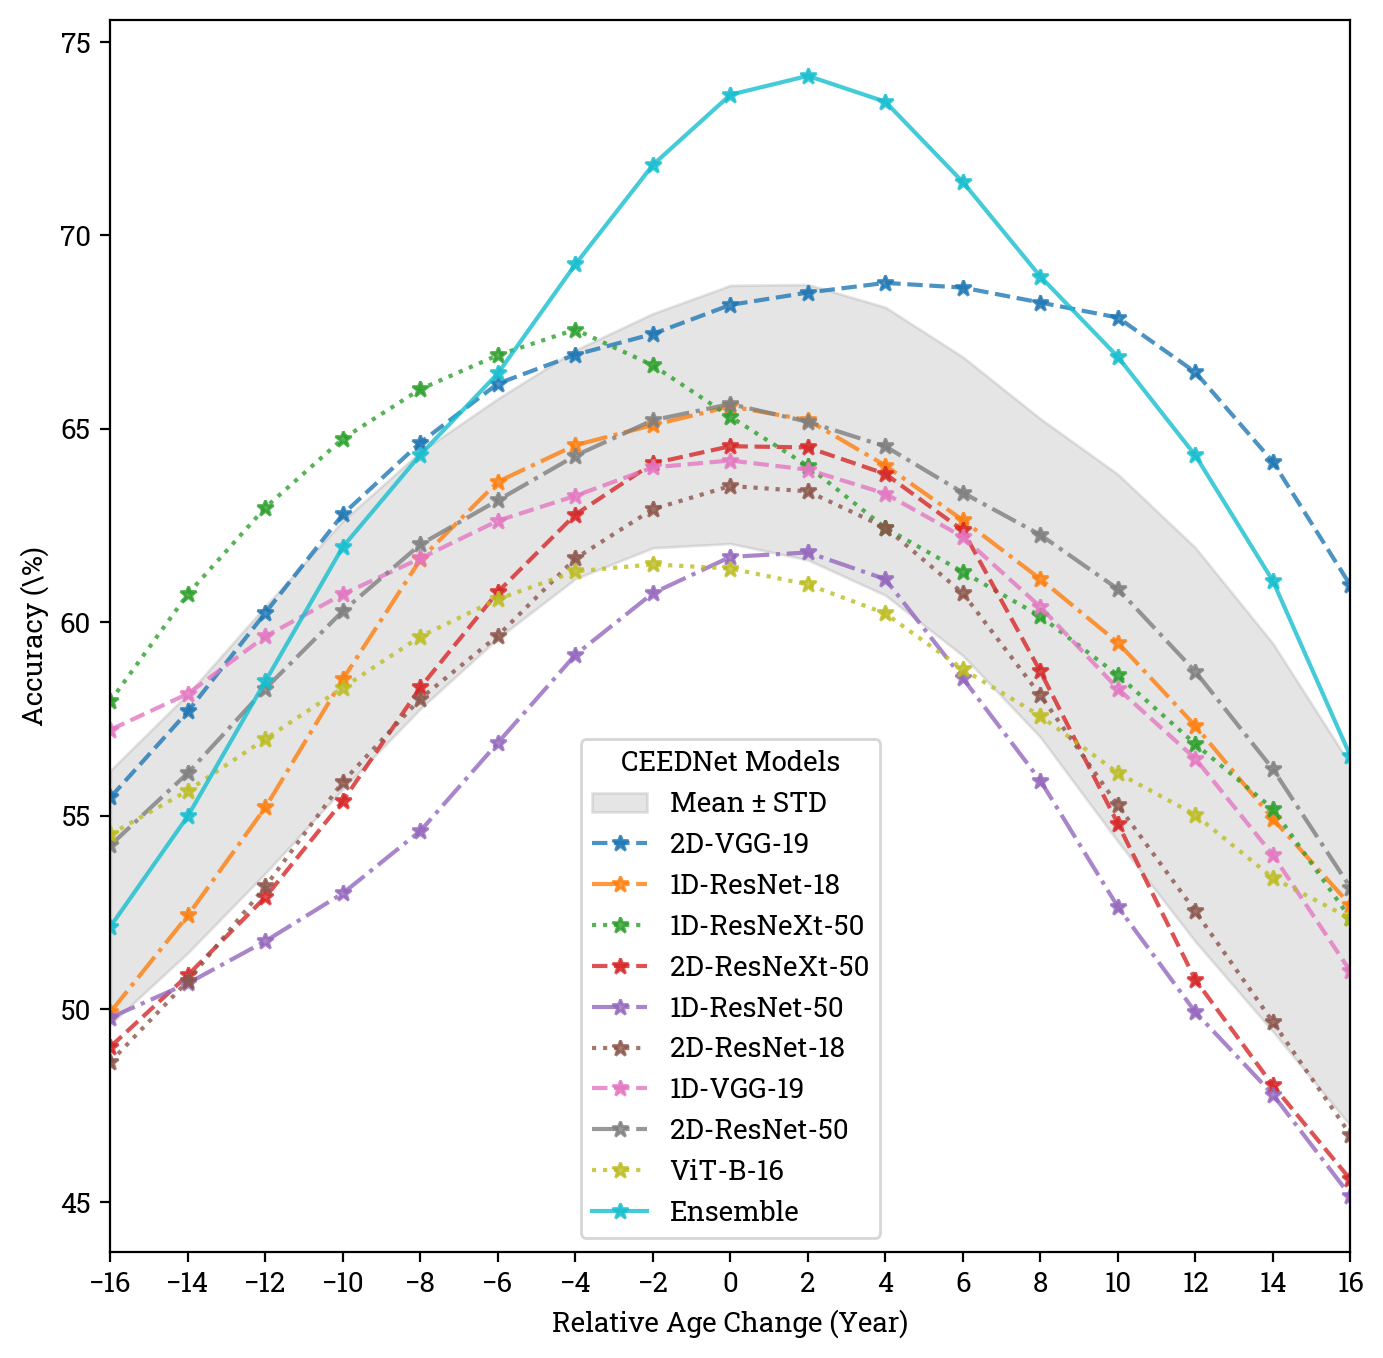

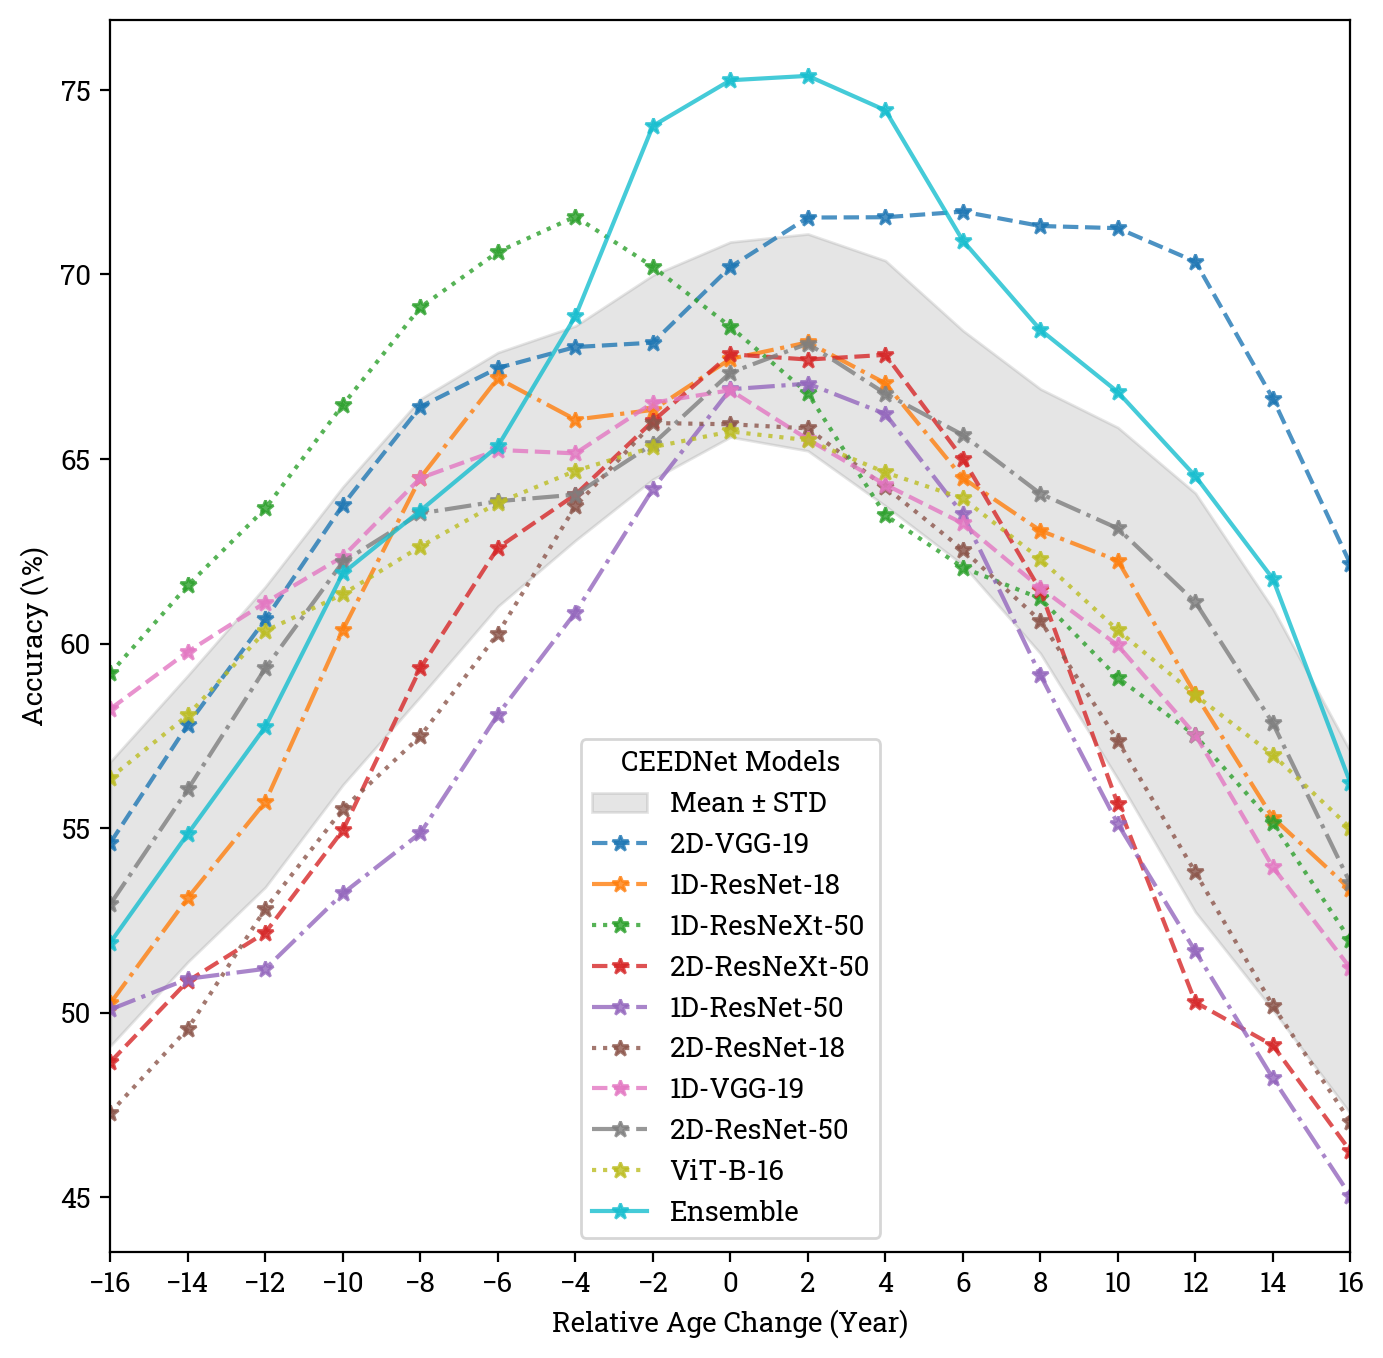

In [6]:
import scienceplots
import matplotlib.pyplot as plt

# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams["font.family"] = 'Roboto Slab' # 'NanumGothic' # for Hangul in Windows
plt.style.use('classic') 
plt.style.use('default') 
plt.style.use('default') # default, ggplot, fivethirtyeight, bmh, dark_background, classic
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Roboto Slab'})
plt.rcParams["savefig.dpi"] = 1200

linestyles = ['--', '-.', ':', '--', '-.', ':', '--', '-.', ':', '-']
colors = plt.cm.tab10(np.linspace(0, 1, 10))

test_array = np.array([summary[model]['Test'] for model in summary.keys() if model not in ['range']])
test_mean = np.mean(test_array, axis=0)
test_std = np.std(test_array, axis=0)

with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    plt.rcParams.update({'font.family': 'Roboto Slab'})
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.fill_between(np.array(summary['range']), test_mean - test_std, test_mean + test_std, 
                    color='gray', alpha=0.2, label='Mean ± STD')
    ax.set_xticks(np.array(summary['range']))
    ax.set_xlabel('Relative Age Change (Year)')
    ax.set_ylabel('Accuracy (\%)')
    
    for i, model in enumerate([model for model in summary.keys() if model != 'range']):
        if model in ['range']:
            continue
    
        performance = summary[model]
        
        ax.plot(np.array(summary['range']), performance['Test'], label=model, marker='*',
                linestyle=linestyles[i % len(linestyles)], color=colors[i], alpha=0.8)
        
        ax.legend(title='CEEDNet Models')
        ax.autoscale(tight=True, axis='x')


test_array = np.array([summary[model]['TTA'] for model in summary.keys() if model not in ['range']])
test_mean = np.mean(test_array, axis=0)
test_std = np.std(test_array, axis=0)

with plt.style.context(['ieee', 'science', 'default']):  # science, ieee, default, fivethirtyeight
    plt.rcParams.update({'font.family': 'Roboto Slab'})
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.fill_between(np.array(summary['range']), test_mean - test_std, test_mean + test_std, 
                    color='gray', alpha=0.2, label='Mean ± STD')
    ax.set_xticks(np.array(summary['range']))
    ax.set_xlabel('Relative Age Change (Year)')
    ax.set_ylabel('Accuracy (\%)')
    
    for i, model in enumerate([model for model in summary.keys() if model != 'range']):
        if model in ['range']:
            continue
    
        performance = summary[model]
        
        ax.plot(np.array(summary['range']), performance['TTA'], label=model, marker='*',
                linestyle=linestyles[i % len(linestyles)], color=colors[i], alpha=0.8)
        
        ax.legend(title='CEEDNet Models')
        ax.autoscale(tight=True, axis='x')